In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd 
from scipy import interpolate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split,KFold
import matplotlib.patches as patches
import matplotlib.ticker as ticker
plt.rcParams.update({'font.size': 14})

### load wavelet used in synthetic generation

Text(0.5, 1.0, 'Seismic Wavelet')

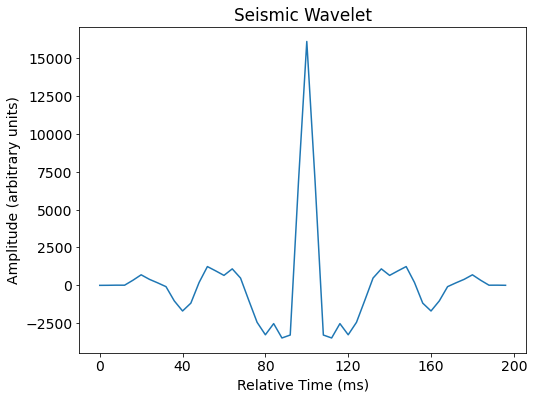

In [2]:
wavelet = np.load('wavelet.npy')
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(wavelet)
ax.set_ylabel('Amplitude (arbitrary units)')
ax.set_xlabel('Relative Time (ms)')
xticks1 = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*4))
ax.xaxis.set_major_formatter(xticks1)
ax.set_title('Seismic Wavelet')
#fig.savefig('wavelet.jpg', dpi=1000, bbox_inches='tight')

# Synthetic Generation

In [3]:
# set number of synthetics to generate and length of each
n_synthetics = 3000
trace_length = 101

# initialize matrices to store synthetics and brittleness labels
synth_matrix = np.zeros((n_synthetics, trace_length))
synth_matrix_originals = np.copy(synth_matrix)
labels= np.zeros(n_synthetics)

# define p wave velocities and densities for the various minerals in the shale caprock
vp_smectite = 5060
vp_quartz = 6040
rho_smectite = 2.613
rho_quartz = 2.65
vp_kaolinite = 3020
rho_kaolinite = 2.616

den_overburden = 2.24
den_underburden = 2.24
vp_overburden = 2400
vp_underburden = 3000

np.random.seed(5)
# generate clay fraction values in normal distribution
dist_clay = np.sort(np.random.normal(0.5, 0.08, n_synthetics))
porosity = 0.25

# function to map clay fraction to brittleness index
def mapping(clay_frac_val, clay_frac_min, clay_frac_max, brittle_min, brittle_max):
    output = (clay_frac_val-clay_frac_min) / (clay_frac_max-clay_frac_min) * (brittle_max-brittle_min) + brittle_min
    return output

# set top and bottom depth of the shale caprock layer
top = 50
bottom = 60

# generate a synthetic for every clay fraction value i, from about 0.2 to 0.8
for i,count in zip(dist_clay, range(n_synthetics)):
    
    #initialize density and vp profiles
    rho_log = np.zeros(trace_length)
    vp_log = np.zeros(trace_length)
    
    # input overburden and underburden density/vp values, and values for caprock based on empirical equations
    rho_log[:top] = den_overburden
    rho_log[top:bottom] = (1-porosity)*((0.7*rho_kaolinite + 0.3*rho_smectite)*i + rho_quartz*(1-i)) + porosity*(1.0)
    rho_log[bottom:] = den_underburden

    vp_log[:top] = vp_overburden
    vp_log[top:bottom] = (1-porosity)*((0.7*vp_kaolinite + 0.3*vp_smectite)*i + vp_quartz*(1-i)) + (1-porosity)*(1500)
    vp_log[bottom:] = vp_underburden

    # calculate acoustic impedance from density and vp product
    I = rho_log * vp_log
    
    # calculate reflection coefficients from acoustic impedance changes at each interface
    Rc=[]
    for j in range(len(I)-1):
        Rc.append((I[j+1]-I[j])/(I[j]+I[j+1]))
    Rc.append(Rc[-1])
    
    # save entry 1500 as an example (moderate brittleness value)
    if count == 1500:
        np.save('vp_ex.npy', vp_log)
        np.save('rho_ex.npy', rho_log)
        np.save('I_ex.npy', I)
        np.save('Rc_ex.npy', Rc)
    
    # generate synthetic through convolution of the wavelet with reflection coefficients
    synthetic = np.convolve(wavelet, Rc, mode='same')
    synth_matrix_originals[count, :] = synthetic
    
    # zero out the synthetic above and below the caprock to avoid the influence of these amplitudes in training
    synthetic[:int(top-10)] = 0
    synthetic[int(bottom+10):] = 0
    
    # save the synthetics
    synth_matrix[count, :] = synthetic
    # map the clay fraction values i to brittleness values using the mapping function
    # from clay frac 0.2 to 0.8, to brittleness 0.2 to 0.6
    labels[count] = mapping(i, 0.2, 0.8, 0.2, 0.6)

### show example 1500 for illustrative purposes

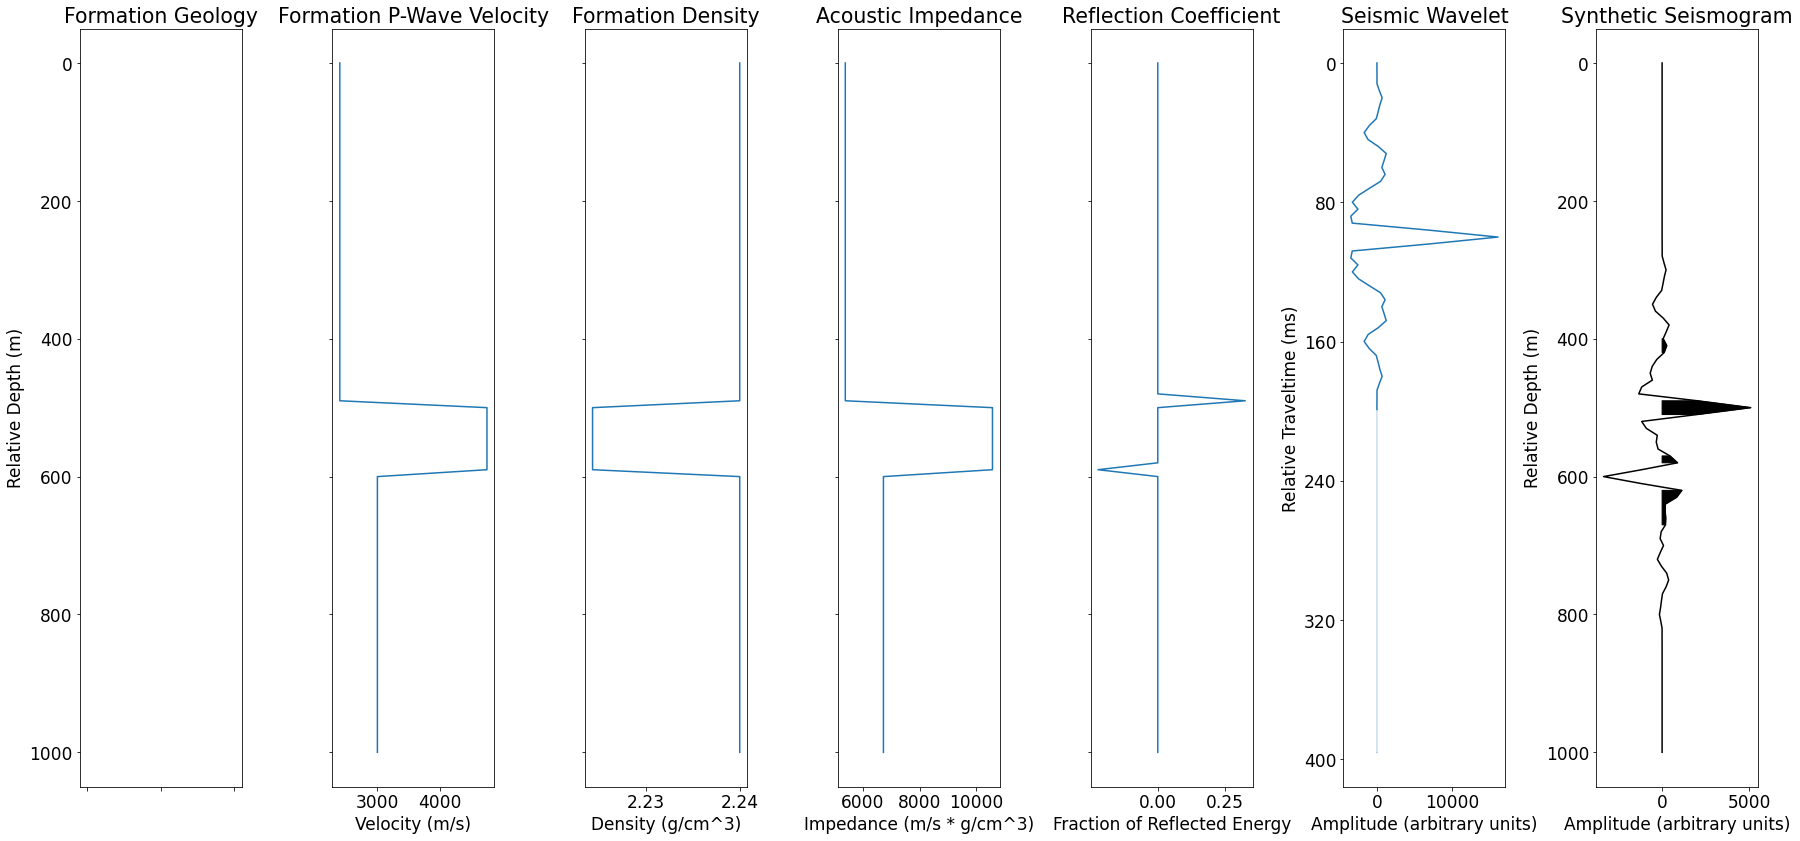

In [4]:
vp_ex = np.load('vp_ex.npy')
rho_ex = np.load('rho_ex.npy')
I_ex = np.load('I_ex.npy')
Rc_ex = np.load('Rc_ex.npy')
synth_ex =  np.convolve(wavelet, Rc_ex, mode='same')
plt.rcParams.update({'font.size': 17})
fig,ax = plt.subplots(1, 7, figsize=(25,12))


ax[0].plot(np.zeros(101), range(101), color='white')
ax[0].invert_yaxis()
yticks0 = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y*10))
ax[0].yaxis.set_major_formatter(yticks0)
ax[0].set_ylabel('Relative Depth (m)')
ax[0].set_title('Formation Geology')
ax[0].xaxis.set_ticklabels([])

ax[1].plot(vp_ex, range(101))
ax[1].invert_yaxis()
ax[1].yaxis.set_ticklabels([])
ax[1].set_xlabel('Velocity (m/s)')
ax[1].set_title('Formation P-Wave Velocity')

ax[2].plot(rho_ex, range(101))
ax[2].invert_yaxis()
ax[2].yaxis.set_ticklabels([])
ax[2].set_xlabel('Density (g/cm^3)')
ax[2].set_title('Formation Density')

ax[3].plot(I_ex, range(101))
ax[3].invert_yaxis()
ax[3].yaxis.set_ticklabels([])
ax[3].set_xlabel('Impedance (m/s * g/cm^3)')
ax[3].set_title('Acoustic Impedance')

ax[4].plot(Rc_ex, range(101))
ax[4].invert_yaxis()
ax[4].yaxis.set_ticklabels([])
ax[4].set_xlabel('Fraction of Reflected Energy')
ax[4].set_title('Reflection Coefficient')


empty = np.zeros(50)
ax[5].plot(np.concatenate((wavelet,empty)), range(100))
ax[5].plot(np.zeros(50), range(50,100), color='white', alpha=1)
ax[5].invert_yaxis()
yticks1 = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y*4))
ax[5].yaxis.set_major_formatter(yticks1)
ax[5].set_xlabel('Amplitude (arbitrary units)')
ax[5].set_ylabel('Relative Traveltime (ms)')
ax[5].set_title('Seismic Wavelet')

ax[6].plot(synth_ex, range(101), color='black')
ax[6].invert_yaxis()
yticks2 = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y*10))
ax[6].yaxis.set_major_formatter(yticks2)
ax[6].set_ylabel('Relative Depth (m)')
ax[6].set_xlabel('Amplitude (arbitrary units)')
ax[6].set_title('Synthetic Seismogram')
ax[6].fill_betweenx(range(101), synth_ex,  0,  synthetic > 0,  color='black')

plt.tight_layout()
#fig.savefig('synth_generation_real_example.jpg', dpi=1000, bbox_inches='tight')

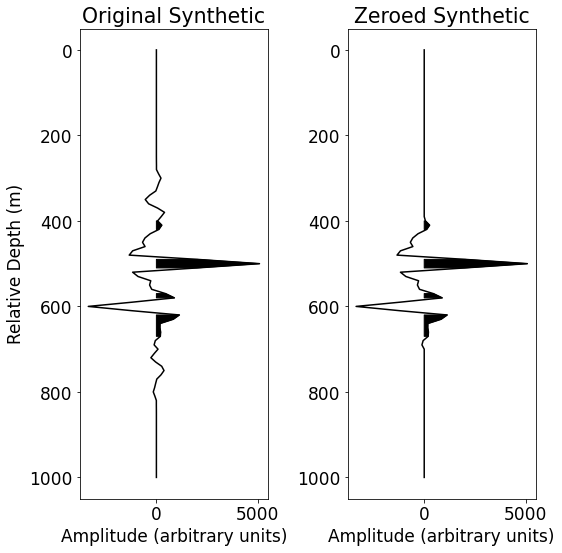

In [8]:
fig,ax = plt.subplots(1, 2, figsize=(8,8))
ax[0].plot(synth_ex, range(101), color='black')
ax[0].invert_yaxis()
yticks2 = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y*10))
ax[0].yaxis.set_major_formatter(yticks2)
ax[0].set_ylabel('Relative Depth (m)')
ax[0].set_xlabel('Amplitude (arbitrary units)')
ax[0].set_title('Original Synthetic')
ax[0].fill_betweenx(range(101), synth_ex,  0,  synthetic > 0,  color='black')

synth_ex_zeroed = np.copy(synth_ex)

synth_ex_zeroed[:int(top-10)] = 0
synth_ex_zeroed[int(bottom+10):] = 0
ax[1].plot(synth_ex_zeroed, range(101), color='black')
ax[1].invert_yaxis()
yticks2 = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y*10))
ax[1].yaxis.set_major_formatter(yticks2)
#ax[1].set_ylabel('Relative Depth (m)')
ax[1].set_xlabel('Amplitude (arbitrary units)')
ax[1].set_title('Zeroed Synthetic')
ax[1].fill_betweenx(range(101), synth_ex,  0,  synthetic > 0,  color='black')
plt.tight_layout()
#fig.savefig('example_synthetic_seismogram_zeroes.jpg', dpi=1000, bbox_inches='tight')

### plot the distribution of clay fraction values and their corresponding brittleness values

Text(0.5, 1.0, 'Distribution of Clay Fraction and Brittleness for Synthetic Data')

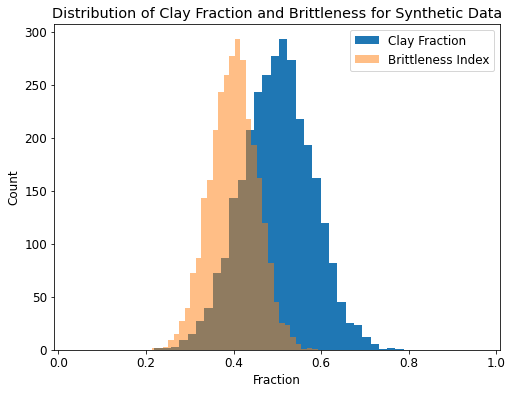

In [104]:
plt.rcParams.update({'font.size': 12})
fig,ax = plt.subplots(figsize=(8,6))

ax.hist(dist_clay, bins=30, label='Clay Fraction');
ax.hist(labels, bins=30, label='Brittleness Index', alpha=0.5);
ax.legend()
ax.set_ylabel('Count')
ax.set_xlabel('Fraction')
ax.set_xlim(-0.01, 1.01)
ax.set_title('Distribution of Clay Fraction and Brittleness for Synthetic Data')
#fig.savefig('dist_clay_and_brittleness.jpg', dpi=1000, bbox_inches='tight')

### plot the highest and lowest brittleness value synthetics

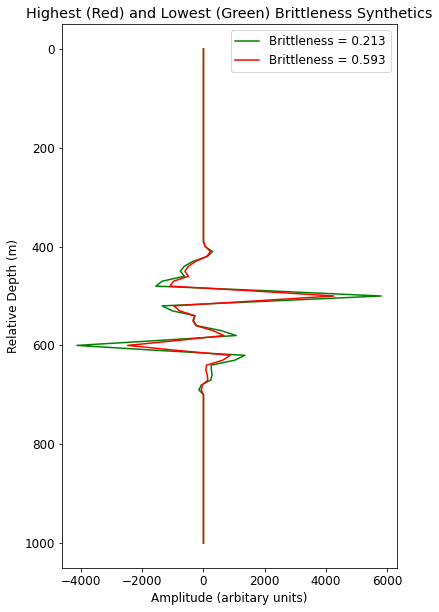

In [11]:
i = 0
plt.rcParams.update({'font.size': 12})
fig,ax = plt.subplots(figsize=(6,10))
ax.plot(synth_matrix[i,:], range(101), label='Brittleness = '+str(round(labels[i], 3)), color='Green')
ax.plot(synth_matrix[-1,:], range(101), label='Brittleness = '+str(round(labels[-1], 3)), color='Red')
ax.invert_yaxis()
yticks0 = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y*10))
ax.yaxis.set_major_formatter(yticks0)
ax.legend(loc='upper right')
ax.set_ylabel('Relative Depth (m)')
ax.set_xlabel('Amplitude (arbitary units)')
ax.set_title('Highest (Red) and Lowest (Green) Brittleness Synthetics')
#fig.savefig('lowest_and_highest_brittle_synthetics.jpg', dpi=1000, bbox_inches='tight')

In [127]:
np.save('synth_matrix.npy', synth_matrix)
np.save('labels.npy', labels)

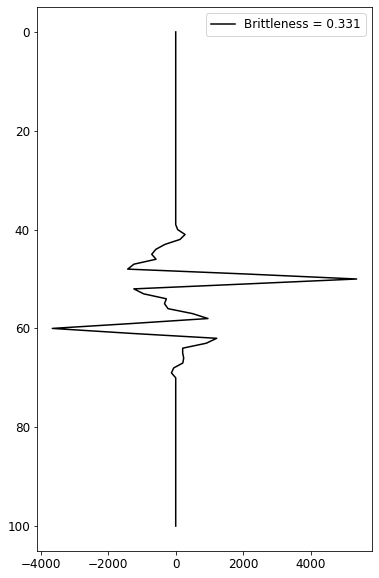

In [134]:
# save trace with brittleness of approximately 0.33, for use in comparing with field data later

i = 300
np.save('synth_example_for_field_compare.npy', synth_matrix[i,:])

fig,ax = plt.subplots(figsize=(6,10))
ax.plot(synth_matrix[i,:], range(101), label='Brittleness = '+str(round(labels[i], 3)), color='Black')
ax.invert_yaxis()
ax.legend()